# Visualizing Separation Analysis

**Gregory Way 2019**

Visualizing GTEx Sex and TARGET MYCN Status Features

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))

Warning message:
“package ‘dplyr’ was built under R version 3.4.4”Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”Warning message:
“package ‘cowplot’ was built under R version 3.4.4”

In [2]:
# Store t test results and identify top features
t_test_results_files <- list.files("results", full.names = TRUE)
t_test_results_files <- t_test_results_files[grepl('t_test', t_test_results_files)]
t_test_results_files

[1] "results/nbl_mycn_separation_target_t_test.tsv"
[2] "results/sex_separation_gtex_t_test.tsv"       
[3] "results/sex_separation_tcga_t_test.tsv"

In [3]:
# Store t test results and identify top features
best_result_list <- list()
line_gg_list <- list()
for (t_test_file in t_test_results_files) {
  full_results_df <- readr::read_tsv(t_test_file,
                                     col_types = readr::cols(
                                       t_stat = readr::col_double(),
                                       t_p = readr::col_double(),
                                       algorithm = readr::col_character(),
                                       feature_num = readr::col_double(),
                                       z_dim = readr::col_double(),
                                       signal = readr::col_character(),
                                       seed = readr::col_double(),
                                       neg_log_p = readr::col_double()
                                       )
                                     )
  
  top_results_df <- full_results_df %>%
    dplyr::group_by(algorithm, z_dim, signal) %>%
    dplyr::filter(neg_log_p == max(neg_log_p),
                  signal == "signal")
  
  # Create factors for plotting
  top_results_df$z_dim <-
    factor(top_results_df$z_dim,
           levels =
             sort(as.numeric(paste(unique(top_results_df$z_dim))))
    )
  
  top_results_df$algorithm <-
    factor(top_results_df$algorithm,
           levels = c("pca", "ica", "nmf", "dae", "vae"))
  
  panel_gg <- ggplot(top_results_df,
                       aes(x = z_dim,
                           y = neg_log_p,
                           color = algorithm,
                           group = algorithm)) +
    geom_smooth(aes(fill = algorithm),
                lwd = 0.3,
                alpha = 0.4,
                method = 'loess',
                formula = 'y ~ x') +
    geom_point(size = 0.5) +
    scale_color_manual(name = "Algorithm",
                       values = c("#e41a1c",
                                  "#377eb8",
                                  "#4daf4a",
                                  "#984ea3",
                                  "#ff7f00"),
                       labels = c("pca" = "PCA",
                                  "ica" = "ICA",
                                  "nmf" = "NMF",
                                  "dae" = "DAE",
                                  "vae" = "VAE")) +
    scale_fill_manual(name = "Algorithm",
                      values = c("#e41a1c",
                                 "#377eb8",
                                 "#4daf4a",
                                 "#984ea3",
                                 "#ff7f00"),
                      labels = c("pca" = "PCA",
                                 "ica" = "ICA",
                                 "nmf" = "NMF",
                                 "dae" = "DAE",
                                 "vae" = "VAE")) +
    theme_bw() +
    ylab("-log10 P Value") +
    xlab("k Dimensions") +
    theme(axis.title.x = element_text(size = 7),
          axis.title.y = element_text(size = 7),
          axis.text.x = element_text(angle = 90,
                                     size = 5),
          axis.text.y = element_text(size = 6),
          plot.title = element_text(size = 8,
                                    hjust = 0.5),
          legend.text = element_text(size = 5),
          legend.title = element_text(size = 6),
          legend.key.size = unit(0.4, "lines"))
  
  
  best_result_df <- top_results_df %>%
    dplyr::arrange(desc(neg_log_p)) %>%
    dplyr::ungroup() %>%
    dplyr::top_n(n = 1, wt = neg_log_p)
  
  best_result_list[[t_test_file]] <- best_result_df
  line_gg_list[[t_test_file]] <- panel_gg
}

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”

## Plot GTEx Sex Example

In [4]:
file <- file.path("..", "0.expression-download", "download", "GTEx_v7_Annotations_SubjectPhenotypesDS.txt")
gtex_pheno_df <- readr::read_tsv(file)

Parsed with column specification:
cols(
  SUBJID = col_character(),
  SEX = col_double(),
  AGE = col_character(),
  DTHHRDY = col_double()
)


In [5]:
best_k_dim <- paste(best_result_list[[t_test_results_files[2]]]$z_dim)
best_seed <- paste(best_result_list[[t_test_results_files[2]]]$seed)
best_feature <- paste0(paste(best_result_list[[t_test_results_files[2]]]$algorithm),
                       "_", 
                       paste(best_result_list[[t_test_results_files[2]]]$feature_num))

In [6]:
print(best_k_dim)
print(best_seed)
print(best_feature)

[1] "200"
[1] "486191"
[1] "vae_108"


In [7]:
feature_file <- file.path("..",
                          "2.sequential-compression",
                          "results",
                          "GTEX_results",
                          "ensemble_z_matrices",
                          paste0("gtex_components_", best_k_dim),
                          paste0("model_", best_seed, "_z_matrix.tsv.gz"))

top_gtex_feature_df <- readr::read_tsv(feature_file,
                                       col_types = readr::cols(
                                           .default = readr::col_double(),
                                           sample_id = readr::col_character()
                                       )
                                      ) %>%
    dplyr::select(sample_id, !!best_feature)

In [8]:
full_gtex_ids <- c()
for (gtex_id in strsplit(top_gtex_feature_df$sample_id, "-")) {
  gtex_id_unlist <- unlist(gtex_id)
  sample_id <- paste0(gtex_id_unlist[1], "-", gtex_id_unlist[2])
  full_gtex_ids <- c(full_gtex_ids, sample_id)
}

top_gtex_feature_df$gtex_id <- full_gtex_ids
top_gtex_feature_df <- top_gtex_feature_df %>%
  dplyr::left_join(gtex_pheno_df, by = c("gtex_id" = "SUBJID"))

top_gtex_feature_df$SEX <- dplyr::recode_factor(top_gtex_feature_df$SEX, `1` = "Male", `2` = "Female")
top_gtex_feature_df$SEX <- factor(top_gtex_feature_df$SEX, levels = c("Female", "Male"))

In [9]:
male_scores <- top_gtex_feature_df %>% dplyr::filter(SEX == "Male") %>% dplyr::pull(vae_108)
female_scores <- top_gtex_feature_df %>% dplyr::filter(SEX == "Female") %>% dplyr::pull(vae_108)

gtex_ttest_result <- t.test(female_scores, male_scores, var.equal = FALSE, paired = FALSE)
gtex_ttest_result


	Welch Two Sample t-test

data:  female_scores and male_scores
t = 124.94, df = 3835.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 4.206840 4.340978
sample estimates:
mean of x mean of y 
4.4611284 0.1872193 


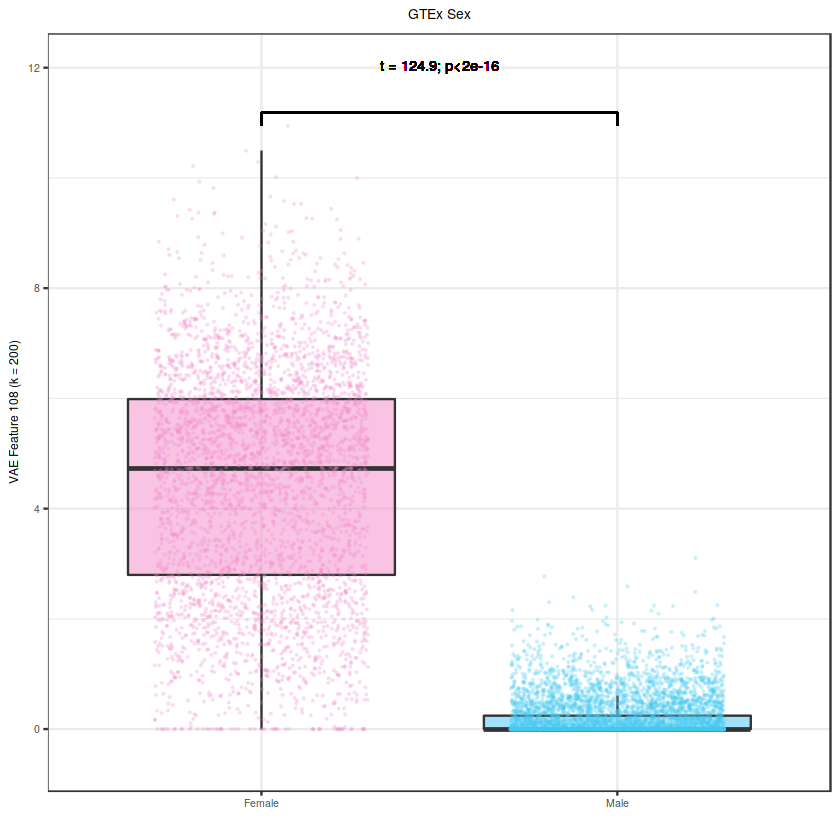

In [10]:
gtex_sex_gg <- ggplot(top_gtex_feature_df,
                      aes(y = vae_108,
                          x = SEX,
                          fill = SEX)) +
  geom_boxplot(alpha = 0.5,
               outlier.alpha = 0) +
  geom_jitter(aes(color = SEX),
              size = 0.15,
              alpha = 0.2,
              width = 0.3) +
  scale_fill_manual(labels = c("Male" = "Male",
                               "Female" = "Female"),
                    values = c("Male" = "#42c8f4",
                               "Female" = "#f489c9")) +
  scale_color_manual(labels = c("Male" = "Male",
                                "Female" = "Female"),
                     values = c("Male" = "#42c8f4",
                                "Female" = "#f489c9")) +
  theme_bw() +
  ylab("VAE Feature 108 (k = 200)") +
  xlab("") +
  ylim(c(-0.5, 12)) +
  ggtitle("GTEx Sex") +
  theme(axis.title.x = element_text(size = 7),
        axis.title.y = element_text(size = 7),
        axis.text.x = element_text(size = 6),
        axis.text.y = element_text(size = 6),
        plot.title = element_text(size = 8,
                                  hjust = 0.5),
        legend.position = "none") +
    geom_segment(aes(x=1,
                     y=max(top_gtex_feature_df$vae_108) + 0.25,
                     xend=2,
                     yend=max(top_gtex_feature_df$vae_108) + 0.25),
                 size=0.4) +
    geom_segment(aes(x=1,
                     y=max(top_gtex_feature_df$vae_108) + 0.25,
                     xend=1,
                     yend=max(top_gtex_feature_df$vae_108)),
                 size=0.4) +
    geom_segment(aes(x=2,
                     y=max(top_gtex_feature_df$vae_108) + 0.25,
                     xend=2,
                     yend=max(top_gtex_feature_df$vae_108)),
                 size=0.4) +
    geom_text(x=1.5,
              y = (max(top_gtex_feature_df$vae_108) + 1.1),
              size = 3.0,
              label = paste0("t = ",
                            round(gtex_ttest_result$statistic, 1),
                            "; p",
                            format.pval(gtex_ttest_result$p.value, digits = 2)))

gtex_sex_gg

## Plot TCGA Sex Example

In [11]:
# Load TCGA phenotype data
file <- file.path("..", "0.expression-download", "download", "TCGA-CDR-SupplementalTableS1.xlsx")
tcga_pheno_df <- readxl::read_xlsx(file, sheet=1, col_types = "text")

print(dim(tcga_pheno_df))
head(tcga_pheno_df)

New names:
* `` -> `..1`


[1] 11160    34


..1,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,⋯,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
1,TCGA-OR-A5J1,ACC,58,MALE,WHITE,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,1,1355,1,1355,1,754,1,754,NA
2,TCGA-OR-A5J2,ACC,44,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,1,1677,1,1677,NA,NA,1,289,NA
3,TCGA-OR-A5J3,ACC,23,FEMALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,0,2091,0,2091,1,53,1,53,NA
4,TCGA-OR-A5J4,ACC,23,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,1,423,1,423,NA,NA,1,126,NA
5,TCGA-OR-A5J5,ACC,30,MALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,1,365,1,365,NA,NA,1,50,NA
6,TCGA-OR-A5J6,ACC,29,FEMALE,BLACK OR AFRICAN AMERICAN,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,0,2703,0,2703,0,2703,0,2703,NA


In [12]:
best_k_dim <- paste(best_result_list[[t_test_results_files[3]]]$z_dim)
best_seed <- paste(best_result_list[[t_test_results_files[3]]]$seed)
best_feature <- paste0(paste(best_result_list[[t_test_results_files[3]]]$algorithm),
                       "_", 
                       paste(best_result_list[[t_test_results_files[3]]]$feature_num))

In [13]:
print(best_k_dim)
print(best_seed)
print(best_feature)

[1] "90"
[1] "451283"
[1] "ica_44"


In [14]:
feature_file <- file.path("..",
                          "2.sequential-compression",
                          "results",
                          "TCGA_results",
                          "ensemble_z_matrices",
                          paste0("tcga_components_", best_k_dim),
                          paste0("model_", best_seed, "_z_matrix.tsv.gz"))

top_tcga_feature_df <- readr::read_tsv(feature_file,
                                       col_types = readr::cols(
                                           .default = readr::col_double(),
                                           sample_id = readr::col_character()
                                       )
) %>%
  dplyr::select(sample_id, !!best_feature)

head(top_tcga_feature_df)

sample_id,ica_44
TCGA-LL-A73Z-01,-0.0066056285
TCGA-55-8207-01,-0.0006632454
TCGA-FF-A7CR-01,-0.0043881237
TCGA-BK-A13C-11,0.0041413864
TCGA-EB-A6L9-06,0.0059281317
TCGA-D8-A145-01,-0.0079013539


In [15]:
full_tcga_ids <- c()
for (tcga_id in strsplit(top_tcga_feature_df$sample_id, "-")) {
  tcga_id_unlist <- unlist(tcga_id)
  sample_id <- paste0(tcga_id_unlist[1], "-", tcga_id_unlist[2], "-", tcga_id_unlist[3])
  full_tcga_ids <- c(full_tcga_ids, sample_id)
}

top_tcga_feature_df$tcga_id <- full_tcga_ids
top_tcga_feature_df <- top_tcga_feature_df %>%
  dplyr::left_join(tcga_pheno_df, by = c("tcga_id" = "bcr_patient_barcode"))

top_tcga_feature_df$gender[is.na(top_tcga_feature_df$gender)] <- "Unlabeled"
top_tcga_feature_df$gender <- dplyr::recode_factor(top_tcga_feature_df$gender,
                                                   "MALE" = "Male",
                                                   "FEMALE" = "Female")
top_tcga_feature_df$gender <- factor(top_tcga_feature_df$gender,
                                     levels = c("Female", "Male", "Unlabeled"))

head(top_tcga_feature_df, 3)

sample_id,ica_44,tcga_id,..1,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,⋯,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
TCGA-LL-A73Z-01,-0.0066056285,TCGA-LL-A73Z,1543,BRCA,55,Female,BLACK OR AFRICAN AMERICAN,Stage IV,[Not Applicable],⋯,NA,1,227,1,227,NA,NA,1,192,NA
TCGA-55-8207-01,-0.0006632454,TCGA-55-8207,6027,LUAD,73,Male,WHITE,Stage IB,[Not Applicable],⋯,NA,0,977,0,977,0,977,0,977,NA
TCGA-FF-A7CR-01,-0.0043881237,TCGA-FF-A7CR,2430,DLBC,61,Male,ASIAN,[Not Applicable],Stage IV,⋯,NA,1,313,1,313,NA,NA,1,290,NA


In [16]:
male_scores <- top_tcga_feature_df %>% dplyr::filter(gender == "Male") %>% dplyr::pull(ica_44)
female_scores <- top_tcga_feature_df %>% dplyr::filter(gender == "Female") %>% dplyr::pull(ica_44)

tcga_ttest_result <- t.test(female_scores, male_scores, var.equal = FALSE, paired = FALSE)
tcga_ttest_result


	Welch Two Sample t-test

data:  female_scores and male_scores
t = 6.3576, df = 9908, p-value = 2.14e-10
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.0008818826 0.0016681128
sample estimates:
    mean of x     mean of y 
 0.0006005141 -0.0006744836 


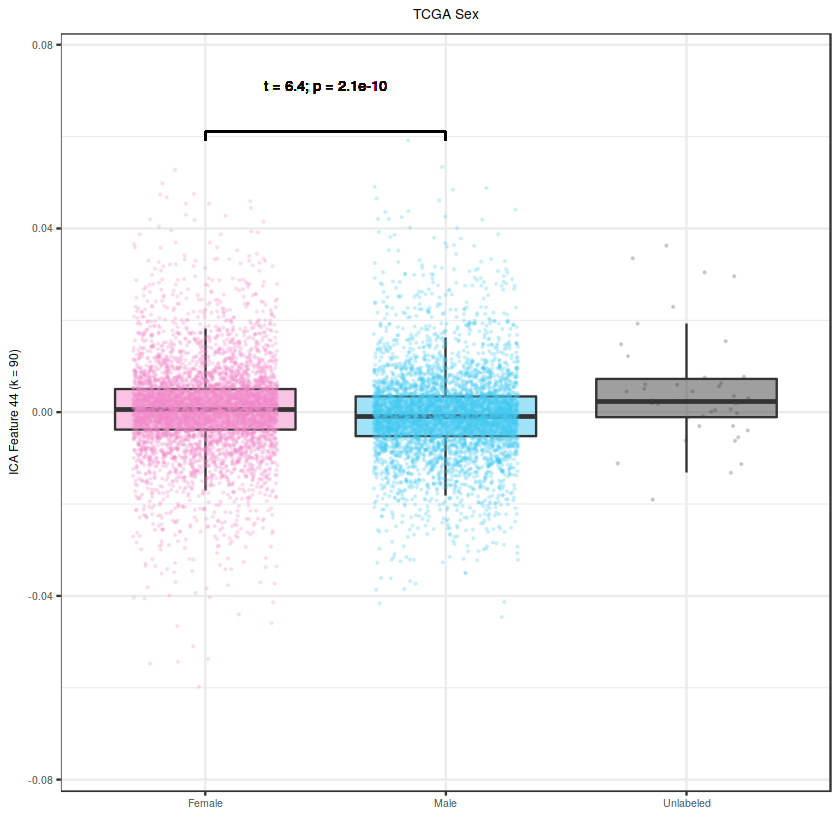

In [17]:
tcga_sex_gg <- ggplot(top_tcga_feature_df,
                      aes(y = ica_44,
                          x = gender,
                          fill = gender)) +
  geom_boxplot(alpha = 0.5,
               outlier.alpha = 0) +
  geom_jitter(aes(color = gender),
              size = 0.15,
              alpha = 0.2,
              width = 0.3) +
  scale_fill_manual(labels = c("Male" = "Male",
                               "Female" = "Female",
                               "Unlabeled" = "Unlabeled"),
                    values = c("Male" = "#42c8f4",
                               "Female" = "#f489c9",
                               "Unlabeled" = "grey25")) +
  scale_color_manual(labels = c("Male" = "Male",
                                "Female" = "Female",
                                "Unlabeled" = "Unlabeled"),
                     values = c("Male" = "#42c8f4",
                                "Female" = "#f489c9",
                                "Unlabeled" = "grey25")) +
  theme_bw() +
  ylim(c(-0.075, 0.075)) +
  ylab("ICA Feature 44 (k = 90)") +
  xlab("") +
  ggtitle("TCGA Sex") +
  theme(axis.title.x = element_text(size = 7),
        axis.title.y = element_text(size = 7),
        axis.text.x = element_text(size = 6),
        axis.text.y = element_text(size = 6),
        plot.title = element_text(size = 8,
                                  hjust = 0.5),
        legend.position = "none") +
    geom_segment(aes(x=1,
                     y=max(top_tcga_feature_df$ica_44) + 0.002,
                     xend=2,
                     yend=max(top_tcga_feature_df$ica_44) + 0.002),
                 size=0.4) +
    geom_segment(aes(x=1,
                     y=max(top_tcga_feature_df$ica_44) + 0.002,
                     xend=1,
                     yend=max(top_tcga_feature_df$ica_44)),
                 size=0.4) +
    geom_segment(aes(x=2,
                     y=max(top_tcga_feature_df$ica_44) + 0.002,
                     xend=2,
                     yend=max(top_tcga_feature_df$ica_44)),
                 size=0.4) +
    geom_text(x=1.5,
              y = (max(top_tcga_feature_df$ica_44) + 0.012),
              size = 3.0,
              label = paste0("t = ",
                            round(tcga_ttest_result$statistic, 1),
                            "; p = ",
                            format.pval(tcga_ttest_result$p.value, digits = 2)))

tcga_sex_gg

## Plot TARGET MYCN Amplification Results

In [18]:
best_k_dim <- paste(best_result_list[[t_test_results_files[1]]]$z_dim)
best_seed <- paste(best_result_list[[t_test_results_files[1]]]$seed)
best_feature <- paste0(paste(best_result_list[[t_test_results_files[1]]]$algorithm),
                       "_", 
                       paste(best_result_list[[t_test_results_files[1]]]$feature_num))

In [19]:
print(best_k_dim)
print(best_seed)
print(best_feature)

[1] "200"
[1] "451283"
[1] "vae_111"


In [20]:
feature_file <- file.path("..",
                          "2.sequential-compression",
                          "results",
                          "TARGET_results",
                          "ensemble_z_matrices",
                          paste0("target_components_", best_k_dim),
                          paste0("model_", best_seed, "_z_matrix.tsv.gz"))

top_mycn_feature_df <- readr::read_tsv(feature_file,
                                       col_types = readr::cols(
                                           .default = readr::col_double(),
                                           sample_id = readr::col_character()
                                       )
                                      ) %>%
  dplyr::select(sample_id, !!best_feature)

In [21]:
# Load TARGET phenotype data
file <- file.path("..", "0.expression-download", "data", "2017-09-30-TARGET update harmonized.txt")
nbl_pheno_df <- readr::read_tsv(file)

full_target_ids <- c()
for (target_id in strsplit(top_mycn_feature_df$sample_id, "-")) {
  target_id_unlist <- unlist(target_id)
  full_target_ids <- c(full_target_ids, target_id_unlist[3])
}

top_mycn_feature_df$target_id <- full_target_ids
top_mycn_feature_df <- top_mycn_feature_df %>% 
  dplyr::inner_join(nbl_pheno_df, by = c("target_id" = "usi"))

head(top_mycn_feature_df, 2)

Parsed with column specification:
cols(
  .default = col_character(),
  `Age at Diagnosis in Days` = col_double(),
  `Event Free Survival Time in Days` = col_double(),
  `Overall Survival Time in Days` = col_double(),
  `Year of Diagnosis` = col_double(),
  `Year of Last Follow Up` = col_double(),
  `Ploidy Value` = col_double()
)
See spec(...) for full column specifications.


sample_id,vae_111,target_id,Gender,Race,Ethnicity,Age at Diagnosis in Days,First Event,Event Free Survival Time in Days,Vital Status,⋯,Histology,Grade,MKI,Diagnostic Category,ICDO,ICDO Description,COG Risk Group,Site Relapse,Comment,target_update
TARGET-30-PARSBI-01,0.00000,PARSBI,Female,White,Not Hispanic or Latino,2390,Relapse,1377,Dead,⋯,Unfavorable,Undifferentiated or Poorly Differentiated,Low,Neuroblastoma,C76.2,"Abdomen, NOS Abdominal wall, NOS Intra-abdominal site, NOS",High Risk,Other metastatic sites,NA,old
TARGET-30-PATBMM-01,0.70011,PATBMM,Male,White,Not Hispanic or Latino,1112,Relapse,653,Alive,⋯,Unfavorable,Undifferentiated or Poorly Differentiated,Low,"Ganglioneuroblastoma, nodular",C74.9,"Adrenal gland, NOS Suprarenal gland Adrenal, NOS",High Risk,Bone,NA,old


In [22]:
amp_scores <- top_mycn_feature_df %>% dplyr::filter(`MYCN status` == "Amplified") %>% dplyr::pull(vae_111)
noamp_scores <- top_mycn_feature_df %>% dplyr::filter(`MYCN status` == "Not Amplified") %>% dplyr::pull(vae_111)

mycn_ttest_result <- t.test(amp_scores, noamp_scores, var.equal = FALSE, paired = FALSE)
mycn_ttest_result


	Welch Two Sample t-test

data:  amp_scores and noamp_scores
t = 10.751, df = 31.094, p-value = 5.331e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 2.313933 3.397262
sample estimates:
mean of x mean of y 
2.9650701 0.1094727 


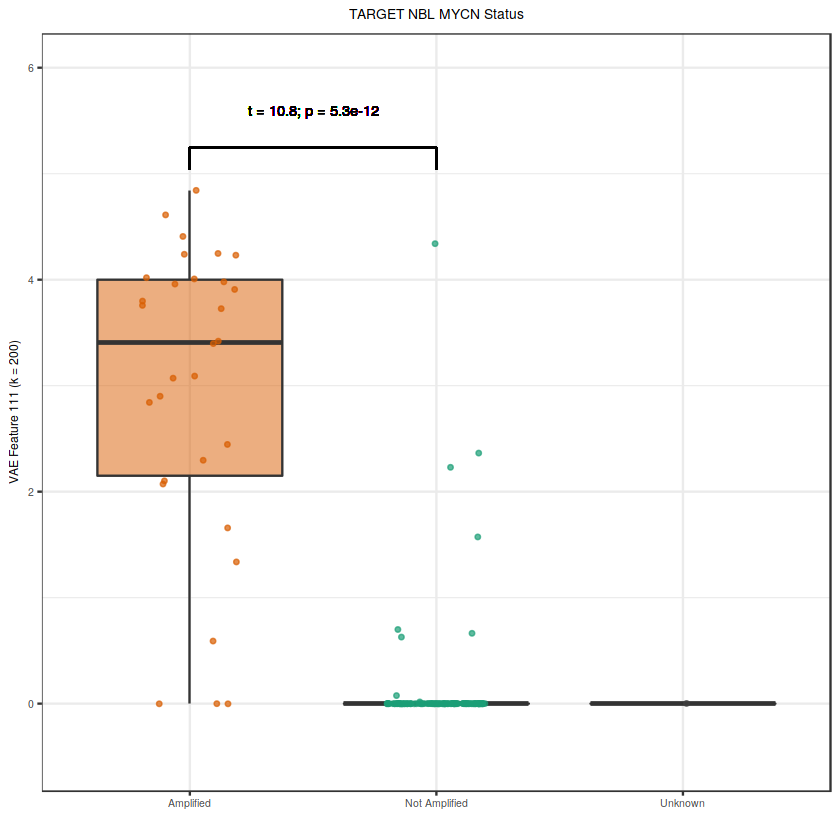

In [23]:
mycn_amp_gg <- ggplot(top_mycn_feature_df,
                      aes(y = vae_111,
                          x = `MYCN status`,
                          fill = `MYCN status`)) +
    geom_boxplot(alpha = 0.5,
               outlier.alpha = 0) +
    geom_jitter(aes(color = `MYCN status`),
              alpha = 0.7,
              size = 0.9,
              width = 0.2) +
    scale_fill_manual(labels = c("Amplified" = "Amplified",
                               "Not Amplified" = "Not Amplified",
                               "Unknown" = "Unknown"),
                    values = c("Amplified" = "#d95f02",
                               "Not Amplified" = "#1b9e77",
                               "Unknown" = "grey25")) +
    scale_color_manual(labels = c("Amplified" = "Amplified",
                                "Not Amplified" = "Not Amplified",
                                "Unknown" = "Unknown"),
                     values = c("Amplified" = "#d95f02",
                                "Not Amplified" = "#1b9e77",
                                "Unknown" = "grey25")) +
    theme_bw() +
    ylab("VAE Feature 111 (k = 200)") +
    xlab("") +
    ggtitle("TARGET NBL MYCN Status") +
    ylim(c(-0.5, 6)) +
    theme(axis.title.x = element_text(size = 7),
       axis.title.y = element_text(size = 7),
       axis.text.x = element_text(size = 6),
       axis.text.y = element_text(size = 6),
       plot.title = element_text(size = 8,
                                 hjust = 0.5),
       legend.position = "none") +
    geom_segment(aes(x=1,
                     y=max(top_mycn_feature_df$vae_111) + 0.4,
                     xend=2,
                     yend=max(top_mycn_feature_df$vae_111) + 0.4),
                 size=0.4) +
    geom_segment(aes(x=1,
                     y=max(top_mycn_feature_df$vae_111) + 0.4,
                     xend=1,
                     yend=max(top_mycn_feature_df$vae_111) + 0.2),
                 size=0.4) +
    geom_segment(aes(x=2,
                     y=max(top_mycn_feature_df$vae_111) + 0.4,
                     xend=2,
                     yend=max(top_mycn_feature_df$vae_111) + 0.2),
                 size=0.4) +
    geom_text(x=1.5,
              y = (max(top_mycn_feature_df$vae_111) + 0.75),
              size = 3.0,
              label = paste0("t = ",
                            round(mycn_ttest_result$statistic, 1),
                            "; p = ",
                            format.pval(mycn_ttest_result$p.value, digits = 2)))

mycn_amp_gg

## Plot MYCN Signature Applied to NBL Cell Lines

In [24]:
file <- file.path("results", "mycn_nbl_scores.tsv")
mycn_validation_df <- readr::read_tsv(file)

mycn_validation_df$`MYCN status` <- dplyr::recode_factor(mycn_validation_df$`MYCN status`,
                                                         "Non-amplified" = "Not Amplified")
mycn_validation_df$`MYCN status` <- factor(mycn_validation_df$`MYCN status`,
                                           levels = c("Amplified", "Not Amplified"))
head(mycn_validation_df)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  vae_111 = col_double(),
  `Cell Line` = col_character(),
  `MYCN status` = col_character(),
  `1p36 del` = col_character(),
  `3p26 del` = col_character(),
  `11q23 del` = col_character(),
  `17q21-qter unbal gain` = col_character(),
  `ALK mutation` = col_character(),
  `p53 mutation` = col_character()
)


X1,vae_111,Cell Line,MYCN status,1p36 del,3p26 del,11q23 del,17q21-qter unbal gain,ALK mutation,p53 mutation
0,6.253521,CHP134,Amplified,LOH p32.3-pter; Gain p34.3-p36.22; Loss p36.22-pter,Gain/AI p26.3,None,Gain q12-qter,WT,WT
1,3.720755,CHP212,Amplified,Loss p13.2-pter,Gain/AI p26.3,cnLOH 23.3,Gain q12-qter,WT,WT
2,4.658529,COGN415,Amplified,Unknown,Unknown,Unknown,Unknown,F1174L,WT
3,5.322958,COGN440,Amplified,Unknown,Unknown,Unknown,Unknown,WT,WT
4,5.996785,COGN453,Amplified,Unknown,Unknown,Unknown,Unknown,F1174L,WT
5,2.920578,COGN496,Amplified,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [25]:
amp_scores <- mycn_validation_df %>% dplyr::filter(`MYCN status` == "Amplified") %>% dplyr::pull(vae_111)
noamp_scores <- mycn_validation_df %>% dplyr::filter(`MYCN status` == "Not Amplified") %>% dplyr::pull(vae_111)

mycn_val_ttest_result <- t.test(amp_scores, noamp_scores, var.equal = FALSE, paired = FALSE)
mycn_val_ttest_result


	Welch Two Sample t-test

data:  amp_scores and noamp_scores
t = 2.4787, df = 12.488, p-value = 0.02834
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.2853467 4.2880819
sample estimates:
mean of x mean of y 
 5.128459  2.841745 


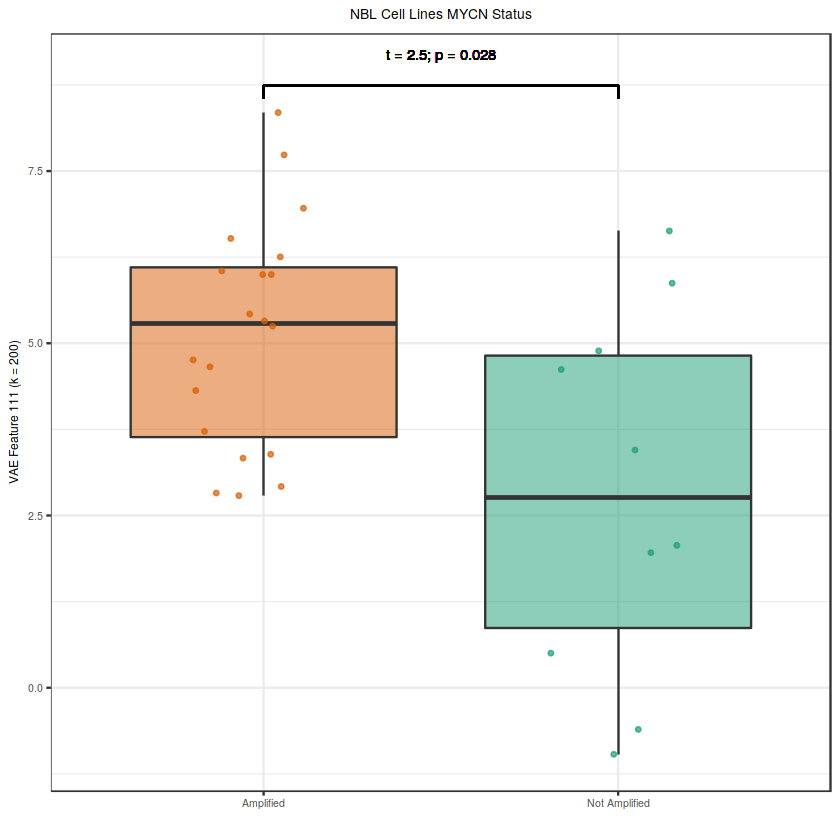

In [26]:
mycn_validation_gg <-
    ggplot(mycn_validation_df,
           aes(y = vae_111,
               x = `MYCN status`,
               fill = `MYCN status`)) +
    geom_boxplot(alpha = 0.5,
               outlier.alpha = 0) +
    geom_jitter(aes(color = `MYCN status`),
              alpha = 0.7,
              size = 0.9,
              width = 0.2) +
    theme_bw() +
    scale_fill_manual(labels = c("Amplified" = "Amplified",
                               "Not Amplified" = "Not Amplified"),
                    values = c("Amplified" = "#d95f02",
                               "Not Amplified" = "#1b9e77")) +
    scale_color_manual(labels = c("Amplified" = "Amplified",
                                "Not Amplified" = "Not Amplified"),
                     values = c("Amplified" = "#d95f02",
                                "Not Amplified" = "#1b9e77")) +
    ylab("VAE Feature 111 (k = 200)") +
    xlab("") +
    ggtitle("NBL Cell Lines MYCN Status") +
    ylim(c(-1, 9)) +
    theme(axis.title.x = element_text(size = 7),
       axis.title.y = element_text(size = 7),
       axis.text.x = element_text(size = 6),
       axis.text.y = element_text(size = 6),
       plot.title = element_text(size = 8,
                                 hjust = 0.5),
       legend.position = "none") +
    geom_segment(aes(x=1,
                     y=max(mycn_validation_df$vae_111) + 0.4,
                     xend=2,
                     yend=max(mycn_validation_df$vae_111) + 0.4),
                 size=0.4) +
    geom_segment(aes(x=1,
                     y=max(mycn_validation_df$vae_111) + 0.4,
                     xend=1,
                     yend=max(mycn_validation_df$vae_111) + 0.2),
                 size=0.4) +
    geom_segment(aes(x=2,
                     y=max(mycn_validation_df$vae_111) + 0.4,
                     xend=2,
                     yend=max(mycn_validation_df$vae_111) + 0.2),
                 size=0.4) +
    geom_text(x=1.5,
              y = (max(mycn_validation_df$vae_111) + 0.85),
              size = 3.0,
              label = paste0("t = ",
                            round(mycn_val_ttest_result$statistic, 1),
                            "; p = ",
                            format.pval(mycn_val_ttest_result$p.value, digits = 2)))

mycn_validation_gg

## Compile Plot

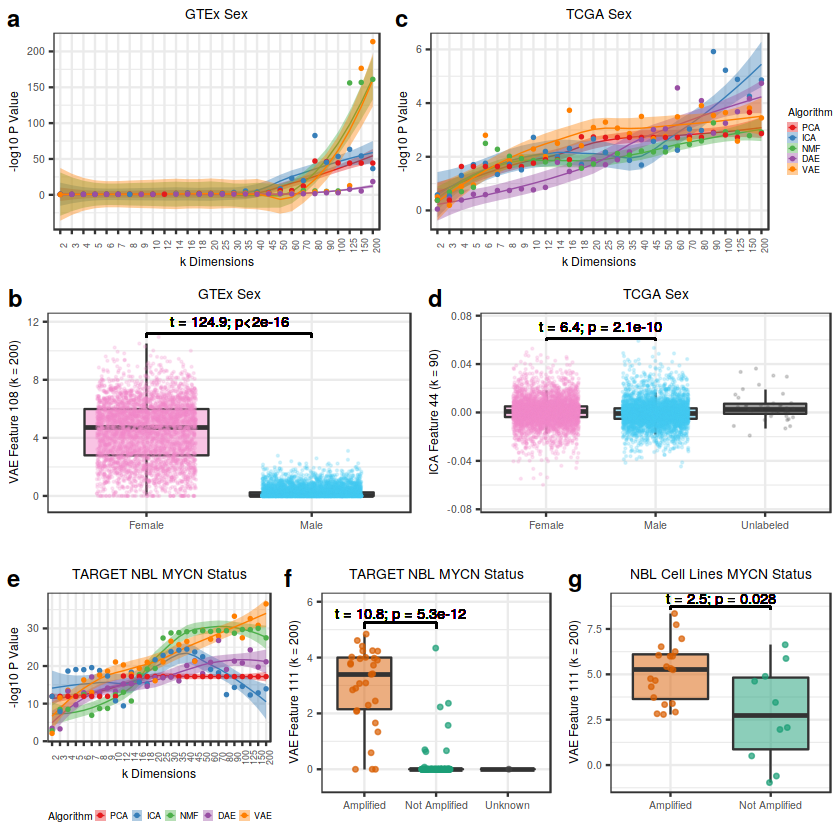

In [27]:
# Plot multi panel figure
line_gg_legend <- cowplot::get_legend(line_gg_list[[1]])

full_line_gg <- cowplot::plot_grid(
    line_gg_list[[2]] +
        theme(legend.position = "none") +
    ggtitle("GTEx Sex"),
        line_gg_list[[3]] +
    theme(legend.position = "none") +
        ggtitle("TCGA Sex"),
    labels = c("a", "c")
)

full_line_gg <- cowplot::plot_grid(full_line_gg,
                                   line_gg_legend,
                                   rel_widths = c(1, 0.08),
                                   ncol = 2)

box_gg <- cowplot::plot_grid(
    gtex_sex_gg,
    tcga_sex_gg,
    labels = c("b", "d"),
    ncol = 2
)


full_nbl_gg <- cowplot::plot_grid(
    line_gg_list[[1]] +
        ggtitle("TARGET NBL MYCN Status") +
        theme(legend.position = "bottom"),
    mycn_amp_gg +
        ggtitle("TARGET NBL MYCN Status"),
    mycn_validation_gg +
        ggtitle("NBL Cell Lines MYCN Status"),
    labels = c("e", "f", "g"),
    ncol = 3
)


main_plot <- cowplot::plot_grid(
    full_line_gg,
    box_gg,
    full_nbl_gg,
    nrow = 3
)

main_plot

In [28]:
for(extension in c('.png', '.pdf')) {
  fig_file <- paste0("full_separation_plot", extension)
  fig_file <- file.path("figures", fig_file)
  cowplot::save_plot(filename = fig_file,
                     plot = main_plot,
                     base_height = 180,
                     base_width = 170,
                     units = "mm")
}